# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [3]:
# %matplotlib qt
import logging
# logging.basicConfig(level=logging.WARNING, format=' - %(levelname)s - %(message)s')

In [4]:
import poppy
from xupy import typings as xt
import xupy as xp
import astropy.units as u
from astropy import convolution as c
from astropy.io import fits
from astropy.table import QTable
from matplotlib import pyplot as plt
from simulator import BinarySystem
from instruments import CCD
import utils as osu

Gpb = QTable.read("data/gaiaDR3passband.fits")
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int, axis_ratio: tuple[int,int] = (1,1)) -> fits.HDUList:
    """
    Rebin PSF by a given factor, following Gaia's pixel scale (1:3 ratio).
    """
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor*axis_ratio[0], rebin_factor*axis_ratio[1])
    return poppy.utils.rebin_array(psf, px_ratio, verbose=True)

```py
poppy.conf.n_processes = 20
poppy.conf.use_cupy = False
poppy.conf.use_multiprocessing = False
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", height=1.45*u.m, width=0.5*u.m)
# M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_pixels=(2124,1062), oversample=1)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

poppy.utils.display_psf(psf[0], title="Gaia PSF", vmax=psf[0][0].data.max())
psf[0].writeto("data/simulations/PSFs/20250923_3_gaia_psf_T.fits", overwrite=True)

## Got The PSF: Now on to the convolution

In [5]:
@osu.timer
def cpu_fft(**kwargs):
    return c.convolve_fft(**kwargs)

@osu.timer
def gpu_fft(**kwargs):
    from processing import convolve_fft
    return convolve_fft(**kwargs)

#### Creating the **Binary Star System (BSS)** and the **CCD**

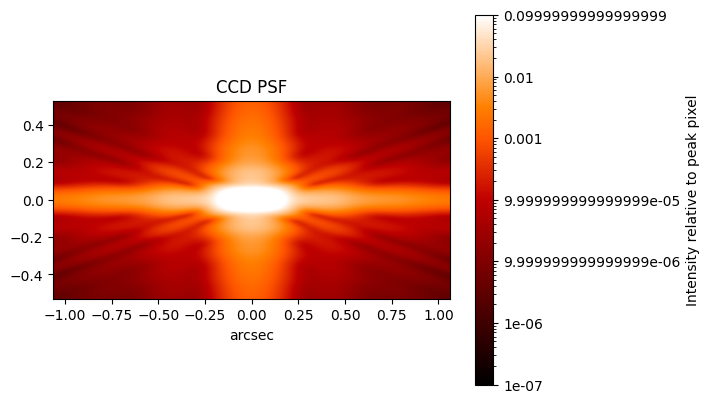

In [12]:
ccd = CCD(psf="data/simulations/PSFs/1062x2124_gpsf.fits")
bs = BinarySystem(ccd=ccd, M1=8, M2=8, distance=200)

ccd.display_psf()

In [13]:
bs._Mtot

7.247425010840047

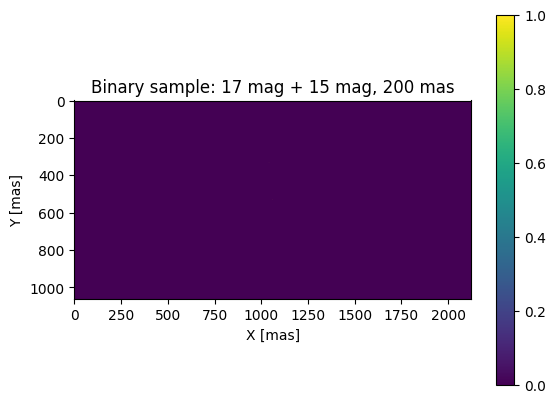

In [10]:
map = bs.show_system(out=True)

In [6]:
cov_g = gpu_fft(image=map, kernel=ccd.psf, dtype=xp.double, normalize_kernel=True)

Execution time: 00:00:0.09 (h:m:s)


In [ ]:
finview = rebinned(cov_g, axis_ratio=(1,3), rebin_factor=59)
plt.imshow(finview, origin='lower', aspect='auto')
plt.title(finview.shape)
px,py = ccd._computeXandYpsf(finview)

In [1]:
from main import main

main()


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 5080 Laptop GPU`
       Memory = 16230.98 MB | Compute Capability = 12.0
       Using CuPy 13.5.1 for acceleration.


/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
[20250924_172349] Observing...:   2%|▏         | 19/1232 [00:05<05:55,  3.42images/s]/mnt/nas/BINCAT/simulator.py:142: RuntimeWarning: divide by zero encountered in scalar divide
  phi = _np.arctan(_np.abs(y[1]-y[0])/_np.abs(x[1]-x[0]))*_u.rad
[20250924_172349] Observing...: 100%|██████████| 1232/1232 [06:09<00:00,  3.34images/s]

20250924_172349


In [1]:
from utils import load_psf

psf = load_psf("data/simulations/observations/20250924_164849/0003.fits")

In [2]:
psf

PSFData(psf='data/simulations/observations/20250924_164849/0003.fits')